In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\0\AppData\Local\Temp\ipykernel_30240\612648604.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


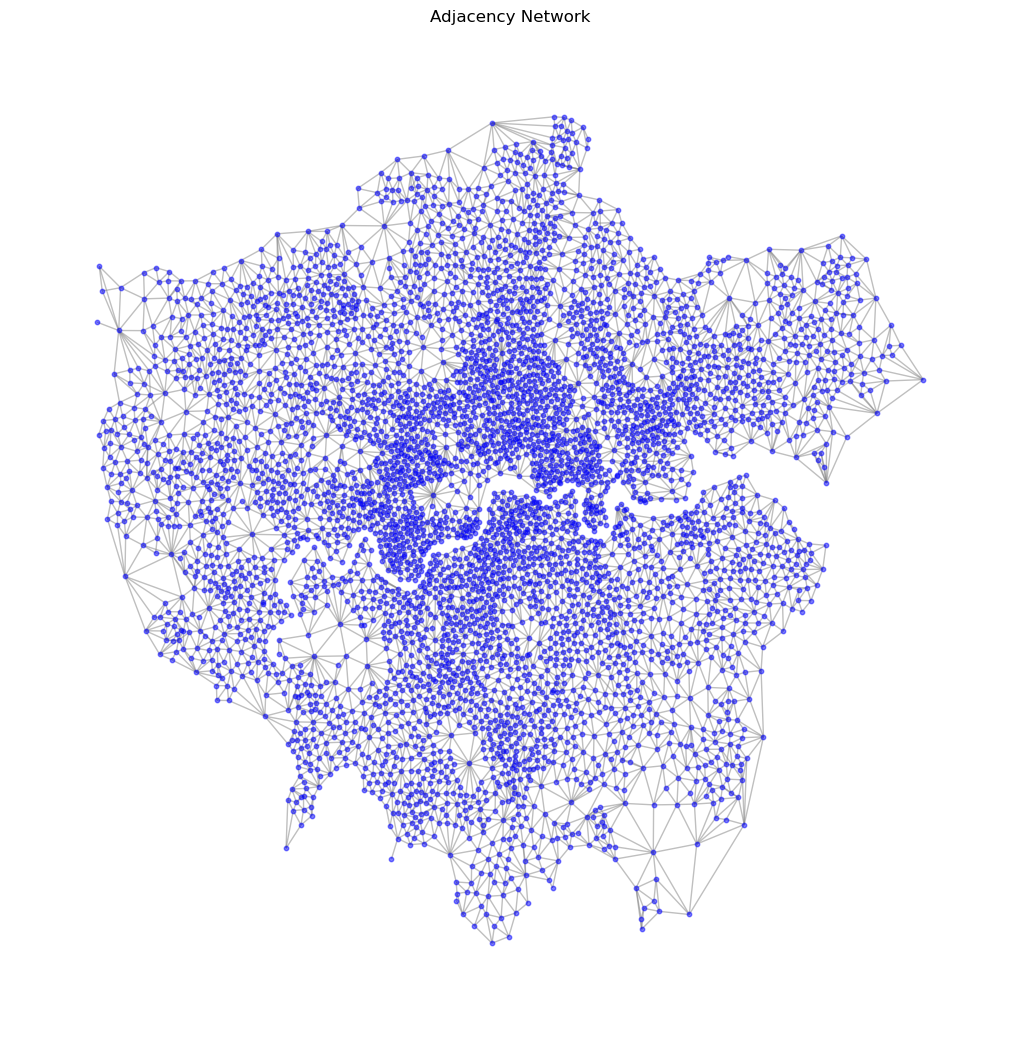

In [2]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

In [3]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    # 'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    # 'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   45.952547
1                       c_percent Aged 15 to 19 years   17.553844
2                       c_percent Aged 20 to 24 years   34.235183
3                       c_percent Aged 25 to 29 years   36.637117
4                       c_percent Aged 30 to 34 years   57.487355
5                       c_percent Aged 35 to 39 years   72.134061
6                       c_percent Aged 40 to 44 years   72.721801
7                       c_percent Aged 65 to 69 years   34.952682
8                       c_percent Aged 70 to 74 years   33.932029
9                       c_percent Aged 75 to 79 years   26.678872
10                      c_percent Aged 80 to 84 years   19.878863
11                   c_percent Aged 85 years and over   10.233184
12                                    c_percent mixed   21.422281
13                                    c_percent white

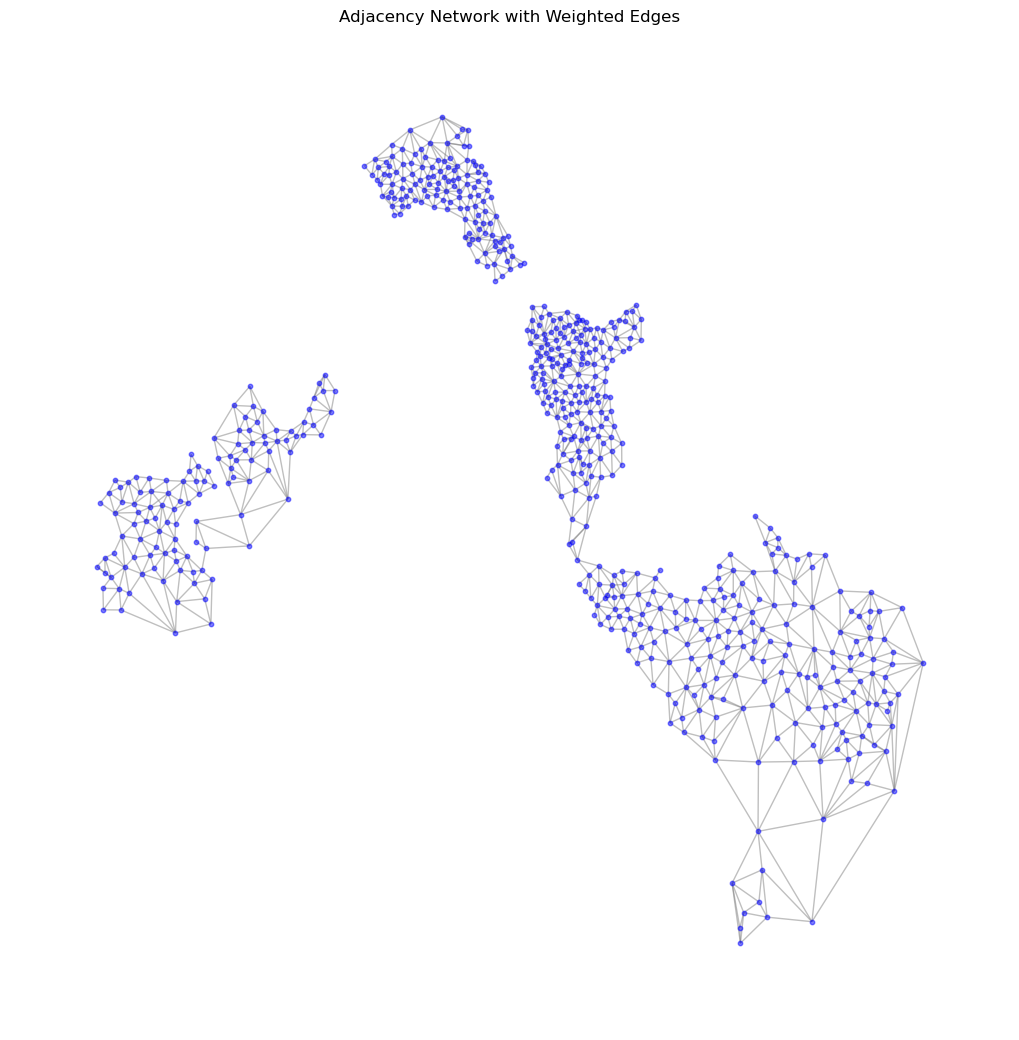

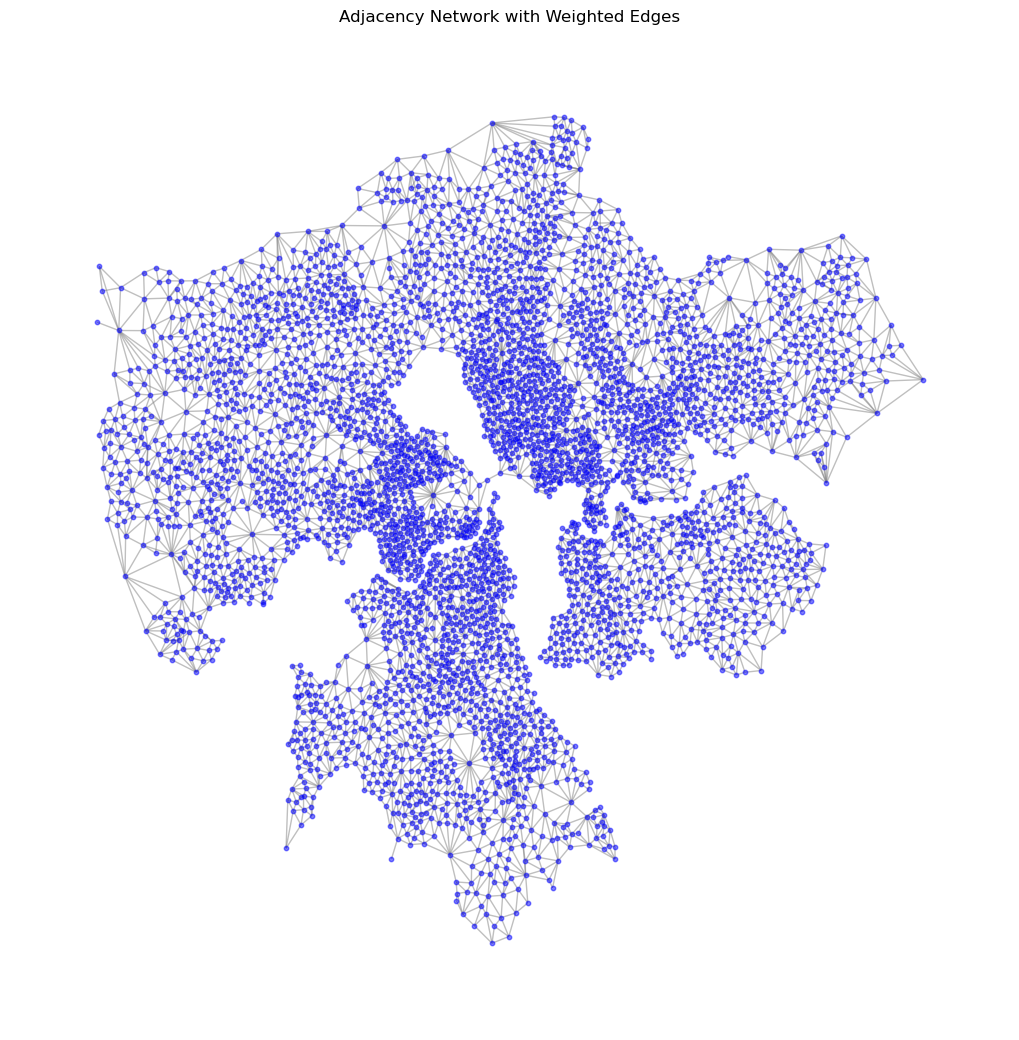

Train data: Data(edge_index=[2, 25468], pos=[4377, 2], weight=[25468], x=[4377, 46], y=[4377, 1])
Test data: Data(edge_index=[2, 3304], pos=[617, 2], weight=[3304], x=[617, 46], y=[617, 1])


In [5]:
# 识别区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_features = final_features_tensor[~is_southwark]
test_features = final_features_tensor[is_southwark]
train_targets = targets[~is_southwark]
test_targets = targets[is_southwark]

# 重新索引训练数据以便与Graph中的节点索引一致
train_indices = np.where(~is_southwark)[0]
test_indices = np.where(is_southwark)[0]

# 构建新的NetworkX图，仅包括训练数据中的节点
train_G = nx.Graph()

# 添加训练数据中的节点
for idx in train_indices:
    train_G.add_node(idx, pos=G.nodes[idx]['pos'])

# 构建训练数据的邻接关系
for idx in train_indices:
    for neighbor in G.neighbors(idx):
        if neighbor in train_indices:
            train_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 构建测试数据的邻接关系
test_G = nx.Graph()
for idx in test_indices:
    test_G.add_node(idx, pos=G.nodes[idx]['pos'])
    for neighbor in G.neighbors(idx):
        if neighbor in test_indices:
            test_G.add_edge(idx, neighbor, weight=G.edges[idx, neighbor]['weight'])

# 将训练数据转换为 PyTorch Geometric 数据
train_data = from_networkx(train_G)
train_data.x = train_features
train_data.y = train_targets

# 将测试数据转换为 PyTorch Geometric 数据
test_data = from_networkx(test_G)
test_data.x = test_features
test_data.y = test_targets

# 可视化邻接关系
pos = nx.get_node_attributes(test_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(test_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()
# 可视化邻接关系
pos = nx.get_node_attributes(train_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(train_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

# 打印检查数据集信息
print("Train data:", train_data)
print("Test data:", test_data)

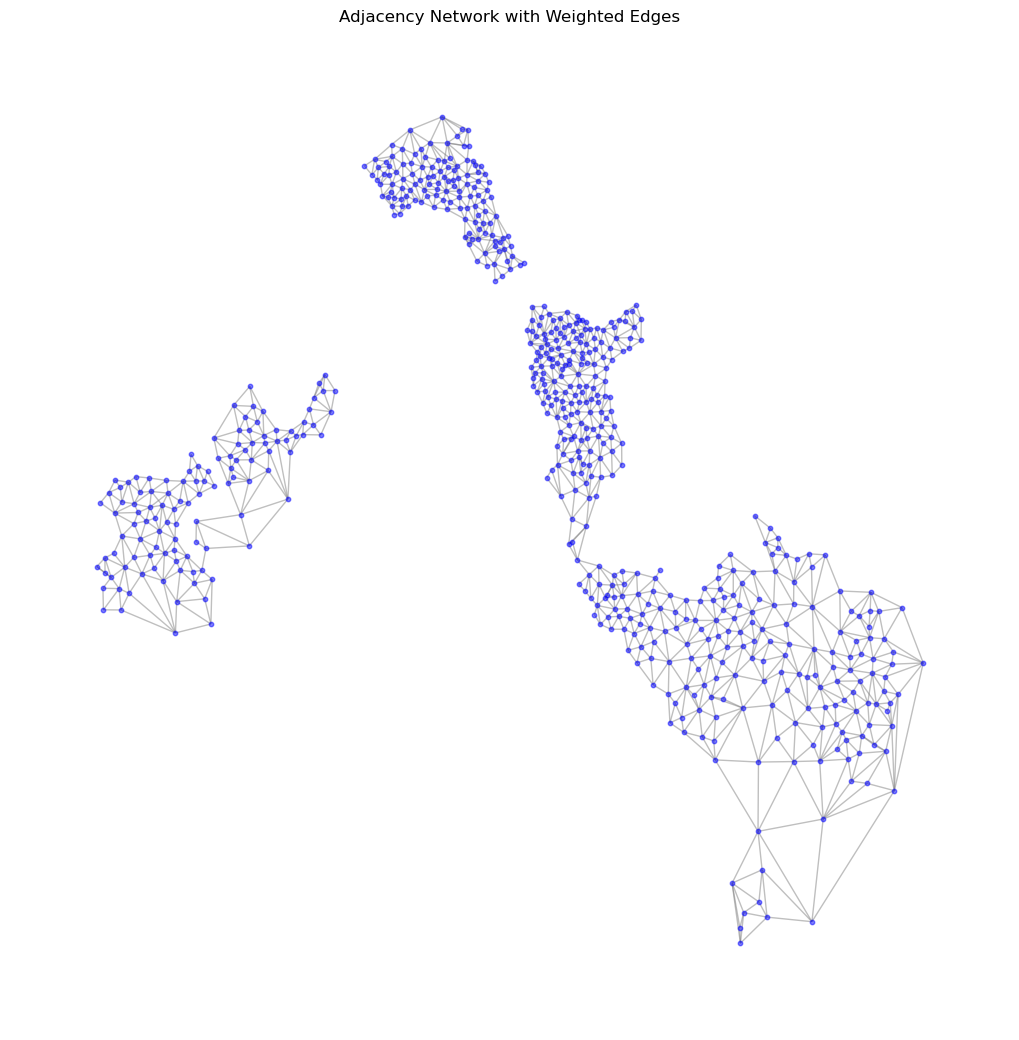

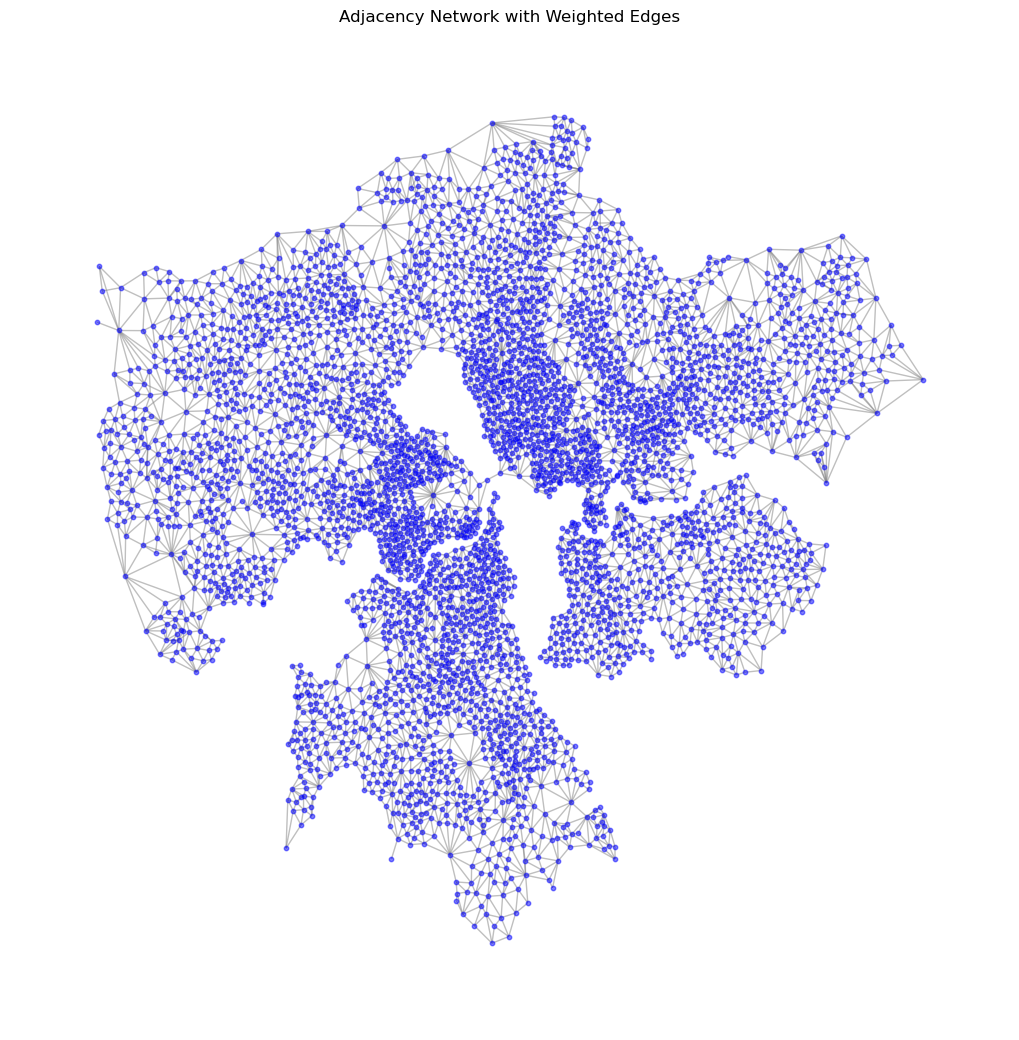

In [18]:
# 可视化邻接关系
pos = nx.get_node_attributes(test_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(test_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()
# 可视化邻接关系
pos = nx.get_node_attributes(train_G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(train_G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

# GIN验证

## 不考虑边界节点

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 10, Loss: 593.8323
Epoch 20, Loss: 513.7208
Epoch 30, Loss: 422.3856
Epoch 40, Loss: 328.5214
Epoch 50, Loss: 236.9567
Epoch 60, Loss: 162.2371
Epoch 70, Loss: 109.3391
Epoch 80, Loss: 79.3601
Epoch 90, Loss: 66.1261
Epoch 100, Loss: 60.0621
Epoch 110, Loss: 57.4139
Epoch 120, Loss: 55.9001
Epoch 130, Loss: 54.5141
Epoch 140, Loss: 54.6853
Early stopping at epoch 145
Epoch 10, Loss: 619.0677
Epoch 20, Loss: 563.0853
Epoch 30, Loss: 486.9038
Epoch 40, Loss: 405.1779
Epoch 50, Loss: 316.9275
Epoch 60, Loss: 231.4521
Epoch 70, Loss: 157.3684
Epoch 80, Loss: 101.3413
Epoch 90, Loss: 70.8555
Epoch 100, Loss: 60.6142
Epoch 110, Loss: 60.1834
Epoch 120, Loss: 52.4607
Epoch 130, Loss: 50.6106
Epoch 140, Loss: 49.0052
Epoch 150, Loss: 45.8467
Epoch 160, Loss: 45.4924
Early stopping at epoch 165
Epoch 10, Loss: 629.4006
Epoch 20, Loss: 620.5662
Epoch 30, Loss: 612.1088
Epoch 40, Loss: 606.5768
Epoch 50, Loss: 598.1808
Epoch 60, Loss: 593.0703
Epoch 70, Loss: 583.4974
Epoch 80, Loss: 578.75

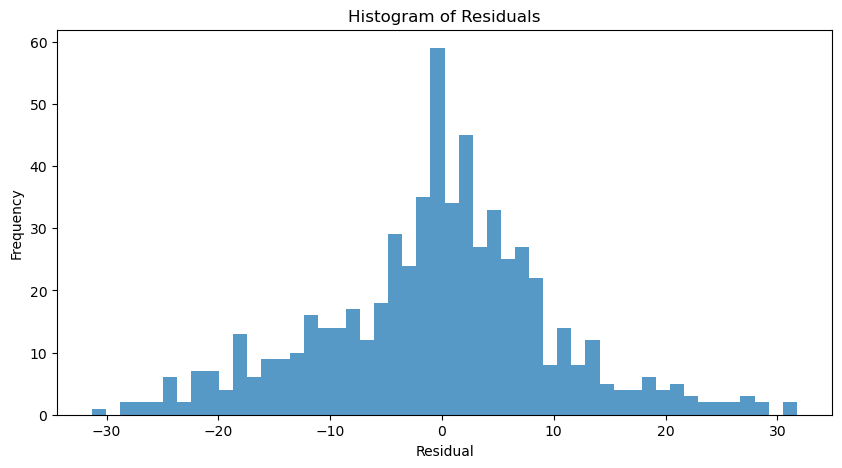

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 定义改进后的GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden1)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


MSE: 15.1932
RMSE: 3.8978
MAE: 2.6260
R²: 0.9043


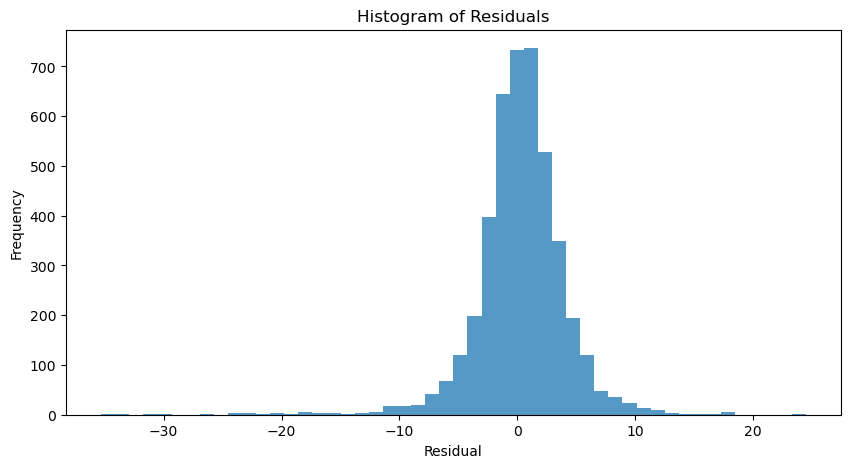

In [11]:
# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(train_data)
    residuals = train_data.y - pred

# 计算评估指标
y_true = train_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## 考虑子图的边界

Testing parameters: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.5}
Epoch 10, Loss: 640.3563
Epoch 20, Loss: 603.6425
Epoch 30, Loss: 561.9703
Epoch 40, Loss: 513.8185
Epoch 50, Loss: 461.3432
Epoch 60, Loss: 392.8907
Epoch 70, Loss: 322.8942
Epoch 80, Loss: 253.9442
Epoch 90, Loss: 193.6227
Epoch 100, Loss: 138.7150
Epoch 110, Loss: 105.5992
Epoch 120, Loss: 77.0655
Epoch 130, Loss: 63.0229
Epoch 140, Loss: 59.5508
Epoch 150, Loss: 55.2194
Epoch 160, Loss: 52.6785
Epoch 170, Loss: 55.9523
Epoch 180, Loss: 48.6461
Epoch 190, Loss: 49.2444
Early stopping at epoch 199
Testing parameters: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 32, 'hidden2': 32, 'dropout': 0.5}
Epoch 10, Loss: 615.9312
Epoch 20, Loss: 566.0971
Epoch 30, Loss: 517.3458
Epoch 40, Loss: 468.1887
Epoch 50, Loss: 408.1119
Epoch 60, Loss: 350.3062
Epoch 70, Loss: 289.1033
Epoch 80, Loss: 232.9128
Epoch 90, Loss: 178.8663
Epoch 100, Loss: 133.4245
Epoch 110, Loss: 104.8829
Epoch 120,

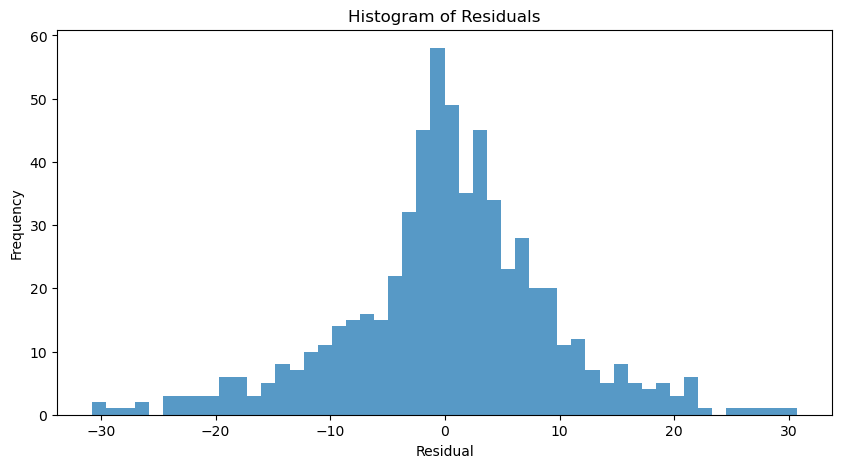

In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden1)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 创建子图时保留边界节点的邻居信息
def create_subgraph(data, indices, original_graph):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    # 保留边界节点的邻居信息
    boundary_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    boundary_mask[sub_edge_index[0]] = True
    boundary_mask[sub_edge_index[1]] = True
    node_mask = node_mask | boundary_mask
    
    sub_edge_index = data.edge_index[:, edge_mask]
    sub_x = data.x[node_mask]
    sub_y = data.y[node_mask]
    
    # 重映射边的索引
    node_idx_map = {idx: i for i, idx in enumerate(torch.where(node_mask)[0].tolist())}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()
    
    subgraph = Data(x=sub_x, edge_index=sub_edge_index, y=sub_y)
    return subgraph

# 识别区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_features = final_features_tensor[~is_southwark]
test_features = final_features_tensor[is_southwark]
train_targets = targets[~is_southwark]
test_targets = targets[is_southwark]

# 重新索引训练数据以便与Graph中的节点索引一致
train_indices = np.where(~is_southwark)[0]
test_indices = np.where(is_southwark)[0]

# 将训练数据转换为 PyTorch Geometric 数据，保留边界节点信息
train_data = create_subgraph(data, train_indices, G)

# 将测试数据转换为 PyTorch Geometric 数据，保留边界节点信息
test_data = create_subgraph(data, test_indices, G)

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 10
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    print(f"Testing parameters: {params}")
    model = GIN(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{200}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


## 考虑主图和子图的边界

Testing parameters: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 32, 'hidden2': 16, 'dropout': 0.5}


C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 10, Loss: 614.9443, Learning Rate: 0.010000
Epoch 20, Loss: 554.0856, Learning Rate: 0.010000
Epoch 30, Loss: 477.8042, Learning Rate: 0.010000
Epoch 40, Loss: 393.3558, Learning Rate: 0.010000
Epoch 50, Loss: 303.1343, Learning Rate: 0.010000
Epoch 60, Loss: 223.1337, Learning Rate: 0.010000
Epoch 70, Loss: 161.4826, Learning Rate: 0.010000
Epoch 80, Loss: 120.2197, Learning Rate: 0.010000
Epoch 90, Loss: 102.3887, Learning Rate: 0.010000
Epoch 100, Loss: 91.1232, Learning Rate: 0.010000
Epoch 110, Loss: 89.6845, Learning Rate: 0.010000
Epoch 120, Loss: 82.9897, Learning Rate: 0.005000
Epoch 130, Loss: 85.1341, Learning Rate: 0.002500
Epoch 140, Loss: 82.5056, Learning Rate: 0.002500
Epoch 150, Loss: 78.7492, Learning Rate: 0.001250
Epoch 160, Loss: 81.4055, Learning Rate: 0.000625
Early stopping at epoch 161
Testing parameters: {'lr': 0.001, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3}
Epoch 10, Loss: 646.7875, Learning Rate: 0.001000
Epoch 20, Loss: 634

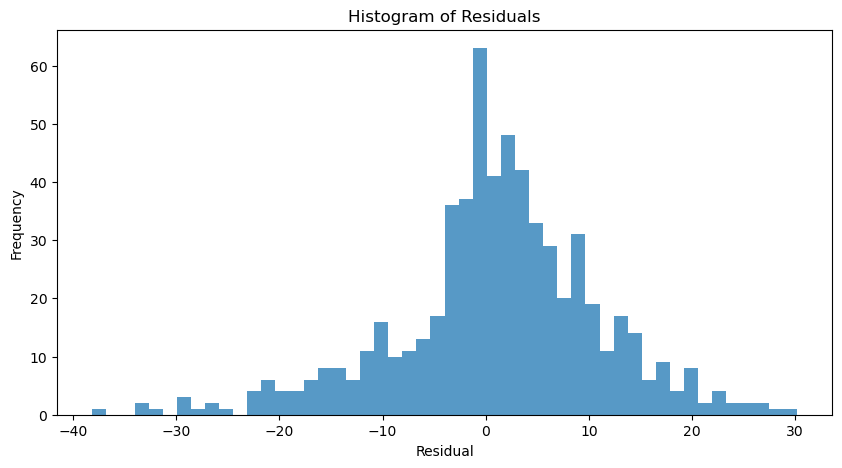

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden1)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    losses = []

    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}")

        losses.append(loss.item())
    
    return best_loss, losses

# 创建子图并标识边界节点及其缺失的邻居信息
def create_subgraph(data, indices):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    boundary_nodes = set()
    missing_neighbors = set()
    for edge in data.edge_index.t().tolist():
        if edge[0] in indices and edge[1] not in indices:
            boundary_nodes.add(edge[0])
            missing_neighbors.add(edge[1])
        elif edge[1] in indices and edge[0] not in indices:
            boundary_nodes.add(edge[1])
            missing_neighbors.add(edge[0])
    
    sub_x = data.x[node_mask]
    sub_y = data.y[node_mask]
    
    node_idx_map = {idx: i for i, idx in enumerate(torch.where(node_mask)[0].tolist())}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()
    
    subgraph = Data(x=sub_x, edge_index=sub_edge_index, y=sub_y)
    return subgraph, boundary_nodes, missing_neighbors

# 更新图中的边界节点信息
def update_boundary_nodes(data, boundary_nodes, missing_neighbors):
    for node in boundary_nodes:
        neighbors = data.edge_index[1][data.edge_index[0] == node].tolist()
        neighbors += data.edge_index[0][data.edge_index[1] == node].tolist()
        neighbors = list(set(neighbors) - missing_neighbors)
        if neighbors:
            data.x[node] += data.x[neighbors].mean(dim=0)
    return data

# 识别区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_indices = np.where(~is_southwark.values)[0]
test_indices = np.where(is_southwark.values)[0]

# 创建图数据对象
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

# 将训练数据转换为 PyTorch Geometric 数据，保留边界节点信息
train_data, train_boundary_nodes, train_missing_neighbors = create_subgraph(data, train_indices)

# 将测试数据转换为 PyTorch Geometric 数据，保留边界节点信息
test_data, test_boundary_nodes, test_missing_neighbors = create_subgraph(data, test_indices)

# 更新拆分子图后的主图中的边界节点信息
data = update_boundary_nodes(data, train_boundary_nodes, train_missing_neighbors)
data = update_boundary_nodes(data, test_boundary_nodes, test_missing_neighbors)

# 更新拆分主图后的子图中的边界节点信息
train_data = update_boundary_nodes(train_data, test_boundary_nodes, test_missing_neighbors)
test_data = update_boundary_nodes(test_data, train_boundary_nodes, train_missing_neighbors)

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5]
}

# 随机搜索
num_samples = 10
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    print(f"Testing parameters: {params}")
    model = GIN(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss, losses = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{200}, Loss: {loss:.4f}, Learning Rate: {current_lr:.6f}")
    losses.append(loss.item())

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 交叉验证

## GIN

Testing parameter set 1/16: {'lr': 0.001, 'weight_decay': 0.0005, 'hidden1': 32, 'hidden2': 16, 'dropout': 0.3, 'num_epochs': 100}
 Split 1/3
  Epoch 0/50, Loss: 660.9914
  Epoch 10/50, Loss: 607.9958
  Epoch 20/50, Loss: 504.6670
  Epoch 30/50, Loss: 337.5477
  Epoch 40/50, Loss: 245.9305
  Epoch 50/50, Loss: 222.5337
  Epoch 60/50, Loss: 209.7486
  Epoch 70/50, Loss: 199.3784
  Epoch 80/50, Loss: 190.3769
  Epoch 90/50, Loss: 185.9987
 Split 2/3
  Epoch 0/50, Loss: 680.2104
  Epoch 10/50, Loss: 642.4818
  Epoch 20/50, Loss: 581.3782
  Epoch 30/50, Loss: 460.0413
  Epoch 40/50, Loss: 313.5729
  Epoch 50/50, Loss: 292.9153
  Epoch 60/50, Loss: 254.8740
  Epoch 70/50, Loss: 245.2098
  Epoch 80/50, Loss: 230.4344
  Epoch 90/50, Loss: 228.3513
 Split 3/3
  Epoch 0/50, Loss: 674.5145
  Epoch 10/50, Loss: 649.0181
  Epoch 20/50, Loss: 594.2573
  Epoch 30/50, Loss: 490.8395
  Epoch 40/50, Loss: 346.5110
  Epoch 50/50, Loss: 315.4067
  Epoch 60/50, Loss: 276.6429
  Epoch 70/50, Loss: 248.9684

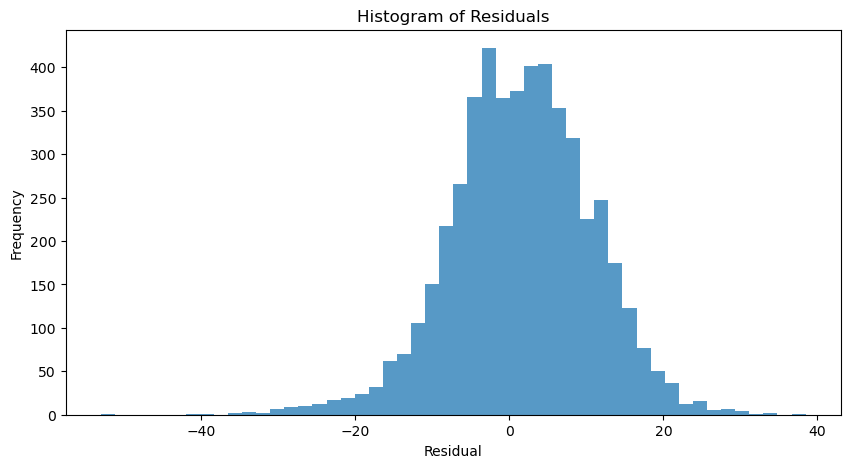

In [15]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_subgraph(data, indices):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    # 重映射边的索引
    node_idx_map = {idx: i for i, idx in enumerate(indices)}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()

    subgraph = Data(x=data.x[indices], edge_index=sub_edge_index, y=data.y[indices])
    return subgraph

def monte_carlo_cross_validation(data, model_class, param_space, num_splits=3, train_ratio=0.7):
    num_nodes = data.x.shape[0]
    best_loss = float('inf')
    best_params = None

    for param_idx, params in enumerate(param_space):
        print(f"Testing parameter set {param_idx + 1}/{len(param_space)}: {params}")
        losses = []
        for split in range(num_splits):
            print(f" Split {split + 1}/{num_splits}")
            indices = np.random.permutation(num_nodes)
            train_size = int(train_ratio * num_nodes)
            train_idx = indices[:train_size]
            val_idx = indices[train_size:]

            train_data = create_subgraph(data, train_idx)
            val_data = create_subgraph(data, val_idx)

            model = model_class(
                in_channels=data.x.shape[1], 
                hidden1=params['hidden1'], 
                hidden2=params['hidden2'], 
                out_channels=data.y.shape[1], 
                dropout=params['dropout']
            ).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            for epoch in range(100):  # 减少训练轮数
                loss = train(model, optimizer, train_data)
                if epoch % 10 == 0:
                    print(f"  Epoch {epoch}/{50}, Loss: {loss:.4f}")

            model.eval()
            with torch.no_grad():
                pred = model(val_data)
                val_loss = F.mse_loss(pred, val_data.y).item()
                losses.append(val_loss)

        avg_loss = np.mean(losses)
        print(f" Average validation loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    return best_params, best_loss

# 定义较小的超参数空间
param_space = [
    {
        'lr': lr, 
        'weight_decay': wd, 
        'hidden1': h1, 
        'hidden2': h2, 
        'dropout': do, 
        'num_epochs': ne
    }
    for lr in [0.001, 0.005]
    for wd in [5e-4, 1e-3]
    for h1 in [32, 64]
    for h2 in [16, 32]
    for do in [0.3]
    for ne in [100]
]

# 假设data已经准备好
# data = your_prepared_data

# 使用GPU加速（如果有GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# 执行蒙特卡洛交叉验证
best_params, best_loss = monte_carlo_cross_validation(data, GIN, param_space)
print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


Testing parameter set 1/4: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 32, 'hidden2': 16, 'dropout': 0.3, 'num_epochs': 100}
 Split 1/3
  Epoch 0/100, Loss: 677.8541
  Epoch 10/100, Loss: 314.2860
  Epoch 20/100, Loss: 263.0070
  Epoch 30/100, Loss: 218.1357
  Epoch 40/100, Loss: 202.4534
  Epoch 50/100, Loss: 186.4696
  Epoch 60/100, Loss: 171.3349
  Epoch 70/100, Loss: 166.0503
  Epoch 80/100, Loss: 161.8823
  Epoch 90/100, Loss: 153.7518
 Split 2/3
  Epoch 0/100, Loss: 657.4855
  Epoch 10/100, Loss: 340.6414
  Epoch 20/100, Loss: 226.8264
  Epoch 30/100, Loss: 203.4361
  Epoch 40/100, Loss: 182.0772
  Epoch 50/100, Loss: 175.6244
  Epoch 60/100, Loss: 168.4757
  Epoch 70/100, Loss: 160.0020
  Epoch 80/100, Loss: 155.3972
  Epoch 90/100, Loss: 147.7109
 Split 3/3
  Epoch 0/100, Loss: 666.2827
  Epoch 10/100, Loss: 301.0040
  Epoch 20/100, Loss: 225.9554
  Epoch 30/100, Loss: 195.3389
  Epoch 40/100, Loss: 183.9475
  Epoch 50/100, Loss: 174.1580
  Epoch 60/100, Loss: 169.9050
  E

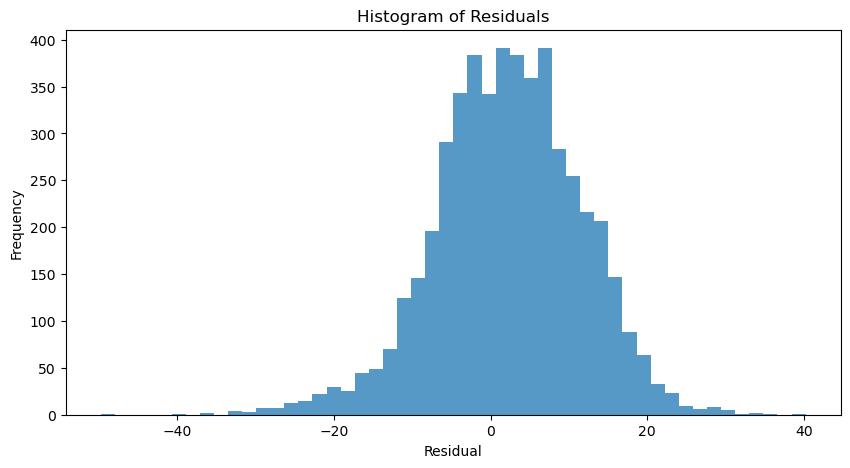

In [16]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_subgraph(data, indices):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    # 保留边界节点的邻居信息
    boundary_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    boundary_mask[sub_edge_index[0]] = True
    boundary_mask[sub_edge_index[1]] = True
    node_mask = node_mask | boundary_mask
    
    sub_edge_index = data.edge_index[:, edge_mask]
    sub_x = data.x[node_mask]
    sub_y = data.y[node_mask]
    
    # 重映射边的索引
    node_idx_map = {idx: i for i, idx in enumerate(torch.where(node_mask)[0].tolist())}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()
    
    subgraph = Data(x=sub_x, edge_index=sub_edge_index, y=sub_y)
    return subgraph

def monte_carlo_cross_validation(data, model_class, param_space, num_splits=3, train_ratio=0.7):
    num_nodes = data.x.shape[0]
    best_loss = float('inf')
    best_params = None

    for param_idx, params in enumerate(param_space):
        print(f"Testing parameter set {param_idx + 1}/{len(param_space)}: {params}")
        losses = []
        for split in range(num_splits):
            print(f" Split {split + 1}/{num_splits}")
            indices = np.random.permutation(num_nodes)
            train_size = int(train_ratio * num_nodes)
            train_idx = indices[:train_size]
            val_idx = indices[train_size:]

            train_data = create_subgraph(data, train_idx)
            val_data = create_subgraph(data, val_idx)

            model = model_class(
                in_channels=data.x.shape[1], 
                hidden1=params['hidden1'], 
                hidden2=params['hidden2'], 
                out_channels=data.y.shape[1], 
                dropout=params['dropout']
            ).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            for epoch in range(100):
                loss = train(model, optimizer, train_data)
                if epoch % 10 == 0:
                    print(f"  Epoch {epoch}/{100}, Loss: {loss:.4f}")

            model.eval()
            with torch.no_grad():
                pred = model(val_data)
                val_loss = F.mse_loss(pred, val_data.y).item()
                losses.append(val_loss)

        avg_loss = np.mean(losses)
        print(f" Average validation loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    return best_params, best_loss

# 定义较小的超参数空间
param_space = [
    {
        'lr': lr, 
        'weight_decay': wd, 
        'hidden1': h1, 
        'hidden2': h2, 
        'dropout': do, 
        'num_epochs': ne
    }
    for lr in [0.005]
    for wd in [5e-4]
    for h1 in [32, 64]
    for h2 in [16, 32]
    for do in [0.3]
    for ne in [100]
]

# 假设data已经准备好
# data = your_prepared_data

# 使用GPU加速（如果有GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# 执行蒙特卡洛交叉验证
best_params, best_loss = monte_carlo_cross_validation(data, GIN, param_space)
print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [20]:
temp = best_params
temp

{'lr': 0.005,
 'weight_decay': 0.0005,
 'hidden1': 32,
 'hidden2': 32,
 'dropout': 0.3,
 'num_epochs': 100}

In [29]:
best_params = {'lr': 0.01,
 'weight_decay': 0.0005,
 'hidden1': 128,
 'hidden2': 16,
 'dropout': 0.3,
 'num_epochs': 200}

Epoch 0/200, Loss: 661.3629
Epoch 10/200, Loss: 269.5350
Epoch 20/200, Loss: 174.8625
Epoch 30/200, Loss: 151.0853
Epoch 40/200, Loss: 141.7527
Epoch 50/200, Loss: 128.4842
Epoch 60/200, Loss: 121.9454
Epoch 70/200, Loss: 117.2285
Epoch 80/200, Loss: 112.1833
Epoch 90/200, Loss: 109.4693
Epoch 100/200, Loss: 104.7451
Epoch 110/200, Loss: 105.5013
Epoch 120/200, Loss: 101.2801
Epoch 130/200, Loss: 96.3699
Epoch 140/200, Loss: 91.2816
Epoch 150/200, Loss: 90.0464
Epoch 160/200, Loss: 89.0793
Epoch 170/200, Loss: 88.1255
Epoch 180/200, Loss: 86.3982
Epoch 190/200, Loss: 82.7274
MSE: 55.3506
RMSE: 7.4398
MAE: 5.7125
R²: 0.6644


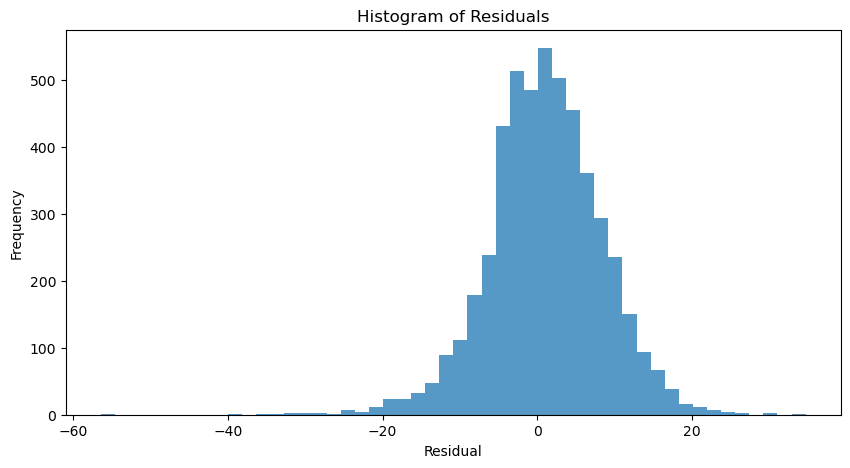

In [30]:
# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# GATv2

### 不考虑边界

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 10, Loss: 541.3614
Epoch 20, Loss: 442.4807
Epoch 30, Loss: 357.8217
Epoch 40, Loss: 285.8547
Epoch 50, Loss: 226.8999
Epoch 60, Loss: 175.5284
Epoch 70, Loss: 137.0646
Epoch 80, Loss: 106.4109
Epoch 90, Loss: 84.6127
Epoch 100, Loss: 72.4926
Epoch 110, Loss: 64.0651
Epoch 120, Loss: 58.8847
Epoch 130, Loss: 55.9497
Epoch 140, Loss: 55.4300
Epoch 150, Loss: 53.1229
Epoch 160, Loss: 51.5977
Epoch 170, Loss: 50.1459
Epoch 180, Loss: 49.8493
Epoch 190, Loss: 52.9486
Early stopping at epoch 197
Epoch 10, Loss: 420.0265
Epoch 20, Loss: 174.7887
Epoch 30, Loss: 66.5542
Epoch 40, Loss: 59.3133
Epoch 50, Loss: 46.3854
Epoch 60, Loss: 39.6383
Epoch 70, Loss: 33.2826
Epoch 80, Loss: 31.2633
Epoch 90, Loss: 28.3257
Epoch 100, Loss: 25.7633
Epoch 110, Loss: 24.1180
Epoch 120, Loss: 22.7732
Epoch 130, Loss: 21.6478
Epoch 140, Loss: 20.0699
Epoch 150, Loss: 20.0751
Epoch 160, Loss: 20.0890
Epoch 170, Loss: 19.5593
Early stopping at epoch 173
Epoch 10, Loss: 80.3004
Epoch 20, Loss: 74.5305
Epoc

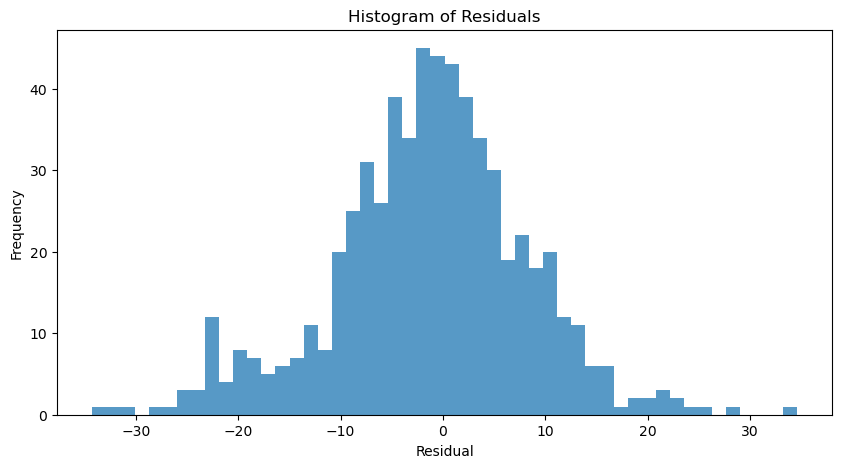

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 定义改进后的GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=8, dropout=dropout)
        self.bn1 = BatchNorm(hidden1 * 8)
        
        self.conv2 = GATv2Conv(hidden1 * 8, hidden2, heads=8, dropout=dropout)
        self.bn2 = BatchNorm(hidden2 * 8)
        
        self.fc1 = torch.nn.Linear(hidden2 * 8, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 10
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GATv2(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


### 考虑子图边界

Testing parameters: {'lr': 0.001, 'weight_decay': 0.001, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.3}


C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 10, Loss: 653.6662
Epoch 20, Loss: 641.1916
Epoch 30, Loss: 630.7908
Epoch 40, Loss: 620.9022
Epoch 50, Loss: 610.5072
Epoch 60, Loss: 600.6088
Epoch 70, Loss: 591.6823
Epoch 80, Loss: 581.3771
Epoch 90, Loss: 571.0140
Epoch 100, Loss: 560.8245
Epoch 110, Loss: 549.3239
Epoch 120, Loss: 538.6485
Epoch 130, Loss: 528.0681
Epoch 140, Loss: 514.1445
Epoch 150, Loss: 501.2562
Epoch 160, Loss: 488.1056
Epoch 170, Loss: 473.7357
Epoch 180, Loss: 457.5519
Epoch 190, Loss: 443.7230
Epoch 200, Loss: 426.8081
Testing parameters: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 32, 'hidden2': 16, 'dropout': 0.7}
Epoch 10, Loss: 627.3320
Epoch 20, Loss: 567.2913
Epoch 30, Loss: 492.8661
Epoch 40, Loss: 408.9135
Epoch 50, Loss: 328.1724
Epoch 60, Loss: 261.5710
Epoch 70, Loss: 209.4674
Epoch 80, Loss: 180.9491
Epoch 90, Loss: 171.7929
Epoch 100, Loss: 164.2318
Epoch 110, Loss: 156.9601
Epoch 120, Loss: 152.0194
Early stopping at epoch 123
Testing parameters: {'lr': 0.005, 'weight_decay': 0.0005

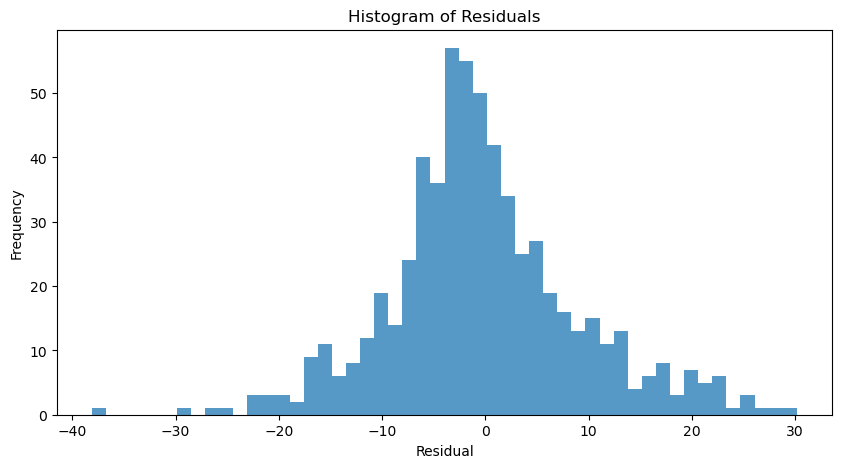

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1)
        self.bn1 = BatchNorm(hidden1)
        
        self.conv2 = GATv2Conv(hidden1, hidden2)
        self.bn2 = BatchNorm(hidden2)
        
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 创建子图时保留边界节点的邻居信息
def create_subgraph(data, indices, original_graph):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    # 保留边界节点的邻居信息
    boundary_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    boundary_mask[sub_edge_index[0]] = True
    boundary_mask[sub_edge_index[1]] = True
    node_mask = node_mask | boundary_mask
    
    sub_edge_index = data.edge_index[:, edge_mask]
    sub_x = data.x[node_mask]
    sub_y = data.y[node_mask]
    
    # 重映射边的索引
    node_idx_map = {idx: i for i, idx in enumerate(torch.where(node_mask)[0].tolist())}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()
    
    subgraph = Data(x=sub_x, edge_index=sub_edge_index, y=sub_y)
    return subgraph

# 识别区域
is_southwark = gdf['LSOA21NM'].str.contains('Bromley|Camden|Southwark|Richmond')

# 划分训练集和测试集
train_features = final_features_tensor[~is_southwark]
test_features = final_features_tensor[is_southwark]
train_targets = targets[~is_southwark]
test_targets = targets[is_southwark]

# 重新索引训练数据以便与Graph中的节点索引一致
train_indices = np.where(~is_southwark)[0]
test_indices = np.where(is_southwark)[0]

# 将训练数据转换为 PyTorch Geometric 数据，保留边界节点信息
train_data = create_subgraph(data, train_indices, G)

# 将测试数据转换为 PyTorch Geometric 数据，保留边界节点信息
test_data = create_subgraph(data, test_indices, G)

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

# 随机搜索
num_samples = 10
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    print(f"Testing parameters: {params}")
    model = GATv2(
        in_channels=train_data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # 确保输出是标量
        dropout=params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, train_data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=train_data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # 确保输出是标量
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{200}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(test_data)
    residuals = test_data.y - pred

# 计算评估指标
y_true = test_data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


Testing parameter set 1/16: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 16, 'dropout': 0.3, 'num_epochs': 50}
 Split 1/3
  Epoch 0/50, Loss: 652.9099
  Epoch 10/50, Loss: 281.6501
  Epoch 20/50, Loss: 186.4352
  Epoch 30/50, Loss: 144.8132
  Epoch 40/50, Loss: 138.6302
 Split 2/3
  Epoch 0/50, Loss: 688.8472
  Epoch 10/50, Loss: 245.9616
  Epoch 20/50, Loss: 197.7305
  Epoch 30/50, Loss: 168.2852
  Epoch 40/50, Loss: 135.2684
 Split 3/3
  Epoch 0/50, Loss: 690.0086
  Epoch 10/50, Loss: 323.8677
  Epoch 20/50, Loss: 186.8608
  Epoch 30/50, Loss: 160.5751
  Epoch 40/50, Loss: 141.9399
 Average validation loss: 128.8035
Testing parameter set 2/16: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 50}
 Split 1/3
  Epoch 0/50, Loss: 666.1050
  Epoch 10/50, Loss: 259.3245
  Epoch 20/50, Loss: 175.9902
  Epoch 30/50, Loss: 143.7993
  Epoch 40/50, Loss: 132.6216
 Split 2/3
  Epoch 0/50, Loss: 673.6580
  Epoch 10/50, Loss: 245.90

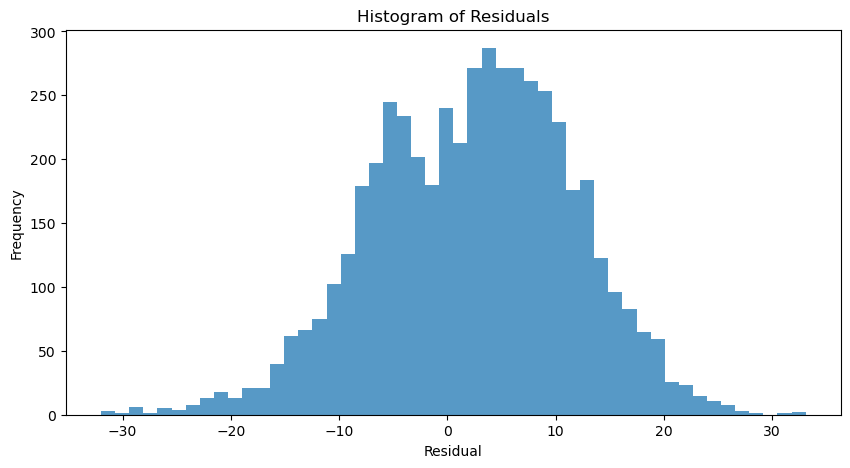

In [15]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_subgraph(data, indices):
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    node_mask[indices] = True
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    sub_edge_index = data.edge_index[:, edge_mask]
    
    # 重映射边的索引
    node_idx_map = {idx: i for i, idx in enumerate(indices)}
    sub_edge_index = torch.tensor([[node_idx_map[n.item()] for n in edge] for edge in sub_edge_index.t()], dtype=torch.long).t()

    subgraph = Data(x=data.x[indices], edge_index=sub_edge_index, y=data.y[indices])
    return subgraph

def monte_carlo_cross_validation(data, model_class, param_space, num_splits=3, train_ratio=0.7):
    num_nodes = data.x.shape[0]
    best_loss = float('inf')
    best_params = None

    for param_idx, params in enumerate(param_space):
        print(f"Testing parameter set {param_idx + 1}/{len(param_space)}: {params}")
        losses = []
        for split in range(num_splits):
            print(f" Split {split + 1}/{num_splits}")
            indices = np.random.permutation(num_nodes)
            train_size = int(train_ratio * num_nodes)
            train_idx = indices[:train_size]
            val_idx = indices[train_size:]

            train_data = create_subgraph(data, train_idx)
            val_data = create_subgraph(data, val_idx)

            model = model_class(
                in_channels=data.x.shape[1], 
                hidden1=params['hidden1'], 
                hidden2=params['hidden2'], 
                out_channels=data.y.shape[1], 
                dropout=params['dropout']
            ).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            for epoch in range(50):  # 减少训练轮数
                loss = train(model, optimizer, train_data)
                if epoch % 10 == 0:
                    print(f"  Epoch {epoch}/{50}, Loss: {loss:.4f}")

            model.eval()
            with torch.no_grad():
                pred = model(val_data)
                val_loss = F.mse_loss(pred, val_data.y).item()
                losses.append(val_loss)

        avg_loss = np.mean(losses)
        print(f" Average validation loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    return best_params, best_loss

# 定义较小的超参数空间
param_space = [
    {
        'lr': lr, 
        'weight_decay': wd, 
        'hidden1': h1, 
        'hidden2': h2, 
        'dropout': do, 
        'num_epochs': ne
    }
    for lr in [0.01, 0.005]
    for wd in [5e-4, 1e-3]
    for h1 in [64,128]
    for h2 in [16, 32]
    for do in [0.3]
    for ne in [50]
]

# 假设data已经准备好
# data = your_prepared_data

# 使用GPU加速（如果有GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# 执行蒙特卡洛交叉验证
best_params, best_loss = monte_carlo_cross_validation(data, GATv2, param_space)
print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [16]:
best_params

{'lr': 0.01,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 32,
 'dropout': 0.3,
 'num_epochs': 50}

In [17]:
best_params = {'lr': 0.01,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 32,
 'dropout': 0.3,
 'num_epochs': 200}

Epoch 0/200, Loss: 674.9436
Epoch 10/200, Loss: 213.0801
Epoch 20/200, Loss: 155.0494
Epoch 30/200, Loss: 130.0587
Epoch 40/200, Loss: 115.9432
Epoch 50/200, Loss: 102.2288
Epoch 60/200, Loss: 95.2489
Epoch 70/200, Loss: 89.9736
Epoch 80/200, Loss: 83.2152
Epoch 90/200, Loss: 77.9128
Epoch 100/200, Loss: 80.2189
Epoch 110/200, Loss: 77.1921
Epoch 120/200, Loss: 72.9864
Epoch 130/200, Loss: 71.2210
Epoch 140/200, Loss: 67.2390
Epoch 150/200, Loss: 64.5523
Epoch 160/200, Loss: 58.9529
Epoch 170/200, Loss: 56.8380
Epoch 180/200, Loss: 54.1291
Epoch 190/200, Loss: 52.4908
MSE: 34.2613
RMSE: 5.8533
MAE: 4.3415
R²: 0.7923


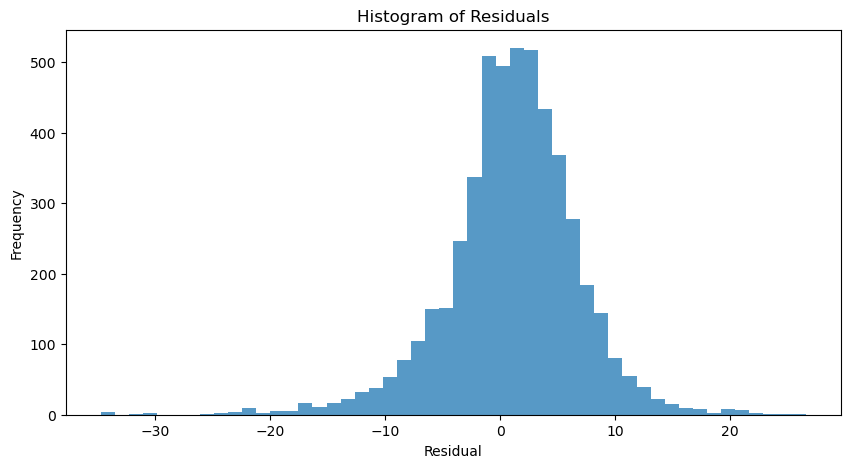

In [18]:
# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.cpu().detach().numpy()
y_pred = pred.cpu().detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.cpu().detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()